Notebook 5: In which we use fully-connected neural networks to identify fish, do a lousy job and ask you to improve upon it by using convolutional neural networks (CNN)
------------------------------------------------------------------------------------------
We will use miniCARP, a restricted version of a library of fish images prepared by the lab as part of __[idtracker.ai](http://idtracker.ai)__ paper  

In [47]:
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.manifold import TSNE
import torchvision
import torch
import torch.nn.functional as F
from torch import nn

from utils import (get_layerw, get_weights, partition_data, plot_history,
                       visualize_pe2D, visualize_MAHD)
from model_ViT import *
from train_eval import *

torch.manual_seed(42)
np.random.seed(42)

In [5]:
#SETTINGS

image_size = 52
patch_size = 4    
in_channels=1
num_heads = 8
#Training
NoAmpt = False
epochs = 150
# path and directory
base_path='/home/carolina/Anansi-00/ViTransformer/miniCarp/' #path where you want to save your model's weights and results
model_name = "ViT_miniCarp_WeightInit01_150epochs_LR0003_WD0.001" #dir name to store your model's w and results
# Data Load and SPLIT
CARP_PATH = '/home/carolina/Anansi-00/ViTransformer/data/miniCARP/'
VALIDATION_FRAMES = 1000
TEST_FRAMES = 1000
params = {'batch_size': 256,
        'shuffle': True,
        'num_workers': 1}
params_test = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 1}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn_Softargmax = nn.Softmax  # fix wrong name

# Load Data

In [7]:
def load_carp(CARP_PATH, fraction=1.0):
    images = np.load(os.path.join(CARP_PATH,'miniCARP_images.npy'))
    labels = np.load(os.path.join(CARP_PATH,'miniCARP_labels.npy'))
    num_images = int(np.floor(images.shape[0]*fraction))
    return images[:num_images], labels[:num_images]

images_uint8, all_labels = load_carp(CARP_PATH, fraction=0.1)

In [8]:
print(images_uint8.shape, all_labels.shape)
print(images_uint8.dtype, all_labels.dtype)
print(images_uint8.min(), images_uint8.max())
print(all_labels, all_labels.min(), all_labels.max())
NUM_LABELS = all_labels.max()+1

(7500, 52, 52) (7500,)
uint8 uint8
0 234
[10  3 10 ...  2  0 13] 0 14


In [9]:
mean = images_uint8.mean()
std = images_uint8.std()
print(mean, std)

25.384570759368835 51.08458280972705


As usual, we transform images to a 0 to 1 range and then remove the mean pixel intensity

In [10]:
#all_images = images_uint8 / images_uint8.max()
#all_images = all_images - all_images.mean()
all_images = (images_uint8 - images_uint8.mean()) / images_uint8.std()
print("New range: {} to {}".format(all_images.min(), all_images.max()))
print(all_images.mean(), all_images.std())

New range: -0.49691255880307084 to 4.0837258085801285
-8.548936268514026e-19 1.0000000000000004


Here, we print some examples, together with the labels. Feel free to change the range of images and labels to be shown

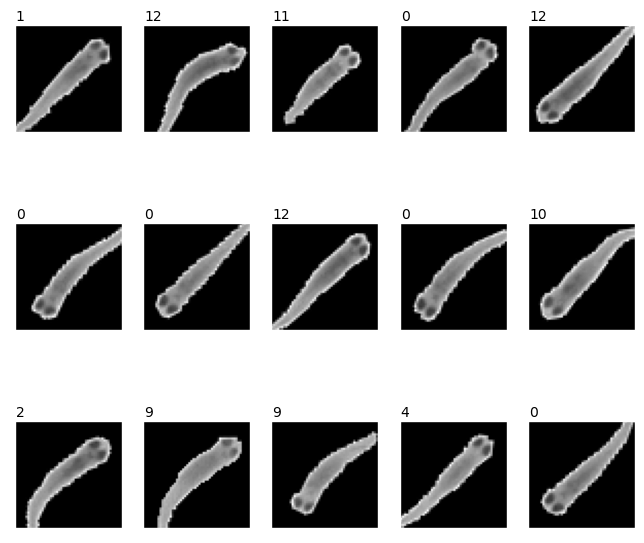

In [11]:
def show_images(images, labels=None):
    fig, axes_rows = plt.subplots(3, len(images)//3, figsize=(8,8))
    axes = [ax for rows in axes_rows for ax in rows]
    for image, ax in zip(images, axes):
        ax.imshow(image,cmap=plt.cm.binary_r)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    if labels is not None:
        for label, ax in zip(labels, axes):
            ax.text(0, -3, label)
    plt.subplots_adjust(wspace=0.2, hspace=-0.1)
    plt.show()
show_images(all_images[200:215], labels=all_labels[200:215]) # Change range here to print other images

We divide the dataset into disjoint train/validation/test datasets

# Dataset Split and Generators

In [12]:
def one_hot(target, num_classes = 15):
    '''
    Converts a vector with all possible indexes/classes in one-hot encoded matrix
    (len(ids), num_classes)
    '''
    #print(target)
    return np.squeeze(np.eye(num_classes)[target])

labels = partition_data(one_hot(all_labels), validation=VALIDATION_FRAMES, test=TEST_FRAMES)
images = partition_data(all_images)

print("Validation and test are fractions {:.2g} and {:.2g}".format(images['validation'].shape[0]/all_images.shape[0],
                                                                images['test'].shape[0]/all_images.shape[0]))


Validation and test are fractions 0.13 and 0.13


In [13]:
images_t = {key: images[key].reshape((-1, 1, images[key].shape[1], images[key].shape[2])) for key in ['train', 'validation', 'test']}

In [14]:
x_train, x_val, x_test = images_t['train'], images_t['validation'], images_t['test']
y_train, y_val, y_test = labels['train'], labels['validation'], labels['test']

print('train data: {}; lables {}'.format(x_train.shape, y_train.shape))
print('test : {}; lables {}'.format(x_val.shape, y_val.shape))
print('test : {}; lables {}'.format(x_test.shape, y_test.shape))

train data: (5500, 1, 52, 52); lables (5500, 15)
test : (1000, 1, 52, 52); lables (1000, 15)
test : (1000, 1, 52, 52); lables (1000, 15)


In [29]:
training_set = Dataset(x_train, y_train)
validation_set = Dataset(x_val, y_val)
test_set = Dataset(x_test[:9], y_test[:9])

# Transformer Functions

In [16]:
assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
num_patches = (image_size // patch_size) ** 2
patch_dim = in_channels * patch_size ** 2
print(num_patches, patch_dim)

169 16


In [17]:
model = ViT(num_layers=12, d_model=32, num_heads=num_heads, conv_hidden_dim=128, patch_size=patch_size, 
            num_answers=15, att_dropout_rate=0, dropout_rate=0,
            num_patches=num_patches, no_embed_classtoken=False, standard1Dpe=False, in_channels=in_channels, 
            cnn=False, class_token=True, add_pos_emb=True, pool='', classif_hidden=128,
            pre_logits=False, weight_init=False)
model.to(device)

ViT(
  (embedding): Embeddings(
    (patch_embeddings): Conv2d(1, 32, kernel_size=(4, 4), stride=(4, 4), padding=valid)
  )
  (pos_embed): PositionalEncoding()
  (pos_dropout): Dropout(p=0, inplace=False)
  (enc_layers): ModuleList(
    (0): EncoderLayer(
      (layernorm1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=32, bias=False)
        (W_k): Linear(in_features=32, out_features=32, bias=False)
        (att_dropout): Dropout(p=0, inplace=False)
        (proj_dropout): Dropout(p=0, inplace=False)
        (W_v): Linear(in_features=32, out_features=32, bias=False)
        (W_h): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout1): Dropout(p=0, inplace=False)
      (layernorm2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
      (cnn): CNN(
        (k1convL1): Linear(in_features=32, out_features=128, bias=True)
        (activation): GELU(approximate=none)
      

In [18]:
if NoAmpt:
    optimizer = None
    factor = 0.5
    th = 0.1 #0.1 = 10 epochs of nb_batches=22
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)
    factor=0
    th=0
train_eval = Training(model, epochs, model_name, optimizer=optimizer, criterion=F.cross_entropy, base_path=base_path, debug=True)
train_eval.print_parameters()

163,535 total parameters.
163,535 training parameters.



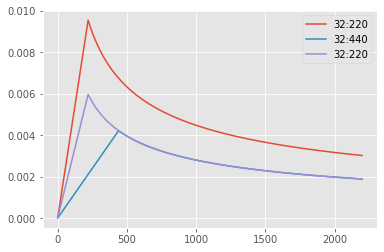

In [ ]:
# PLOT LR
d = 32
n_batches = 22
th = 0.1
epochs=100
training_steps = int(th * (epochs*n_batches))
#training_steps = int(th * n_batches)
opts = [NoamOpt(d, 0.8, training_steps, None),  #d_model, factor, warmup, optimizer
        NoamOpt(d, 0.5, training_steps*2, None),
        NoamOpt(d, 0.5, training_steps, None)]
plt.plot(np.arange(1, int(training_steps*10)), [[opt.rate(i) for opt in opts] for i in range(1, int(training_steps*10))])
plt.legend([f"{d}:{training_steps}", f"{d}:{training_steps*2}", f"{d}:{training_steps}"])

# Visualize ViT representations

In [19]:
# load the best model checkpoint
best_model_cp = torch.load('{}weights/{}/best_model.pth'.format(base_path, model_name))
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")
#print(f"Val Accuracy {train_eval.history['val_Accuracy'][best_model_epoch]} and Loss {train_eval.history['val_Loss'][best_model_epoch]}")

Best model was saved at 148 epochs



In [20]:
print('Loading best epoch saved model weights...')
model.load_state_dict(best_model_cp['model_state_dict'])

Loading best epoch saved model weights...


<All keys matched successfully>

In [30]:
def test_model(model, test_loader, n=None):
  np.random.seed(0)
  model.eval()
  with torch.no_grad():
    for batch in test_loader:
      x = batch[0].float().to(device)
      y = batch[1].float().to(device)

      out, A = model(x)
      preds = out.argmax(1).detach().cpu().numpy()
      targets = y.argmax(1).detach().cpu().numpy()
      #print(x.size(), A['layer_0'].size())

      if n is not None:
        #random selection of n//2 wrongly predicted images
        wrong_pred = np.where(preds!=targets)[0]
        p = np.random.permutation(wrong_pred.shape[0])
        wanted_ids = wrong_pred[p[:n//2]]
        gt_mislabeled = targets[wanted_ids]
        print("gt_mislabeled: ", gt_mislabeled)

        #for each wrong predicted class selected, select a correct prediction of that class
        correct_pred = np.where(preds==targets)[0]
        print("Rate of correct predictions: ", correct_pred.shape[0] / preds.shape[0])
        for gt in np.unique(gt_mislabeled):
          count = np.count_nonzero(gt_mislabeled==gt)
          #print(gt, count)
          gt_correct_ids = np.where(targets[correct_pred]==gt)[0][:count]
          wanted_cids = correct_pred[gt_correct_ids]
          wanted_ids = np.hstack((wanted_ids, wanted_cids))

        #wanted_ids = wanted_ids.reshape(-1)
        print("Wanted image ids: ", wanted_ids)
        image_tensors = x[wanted_ids, :, :, :].detach().cpu().numpy()
        preds = preds[wanted_ids]
        targets = targets[wanted_ids]
        attn_mat = A # for each key/layer: (num_images, num_heads, n_patches, n_patches)
        for k in A.keys():
          attn_mat[k] = A[k][wanted_ids, :, :, :].detach().cpu()
      else:
        attn_mat = A
        for k in A.keys():
          attn_mat[k] = A[k][:, :, :, :].detach().cpu()
        image_tensors = x.detach().cpu().numpy()
        wanted_ids = None
      break

  return image_tensors, targets, preds, attn_mat, wanted_ids

In [31]:
params = {'batch_size': 10,
          'shuffle': False,
          'num_workers': 1}

test_loader_plots = torch.utils.data.DataLoader(test_set, **params)

In [32]:
ex_imgs, ex_gt, pred_labels, attn_weights_dict, _ = test_model(model, test_loader_plots)

/tmp/ipykernel_208342/382952586.py:11: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  im.cmap.set_under("w")


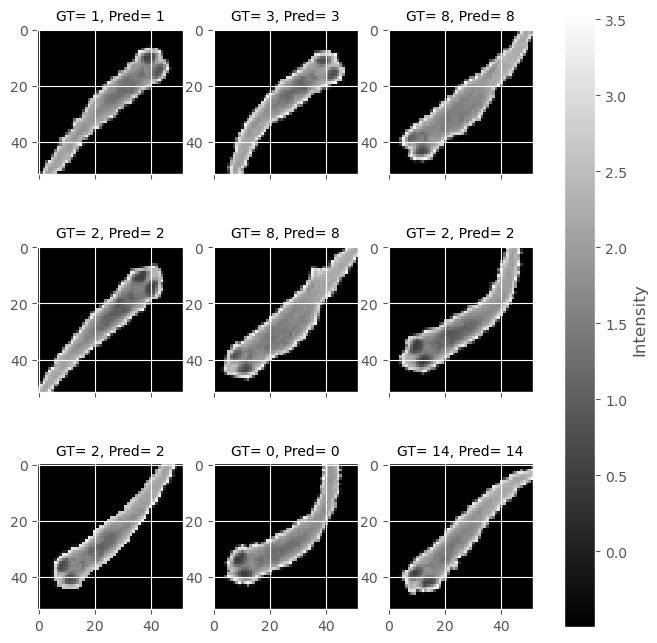

In [33]:
def visualize_imgs(imgs, labels, preds):
  assert len(imgs) % 3 ==0, "Number of image examles should be multiple of 3"
  f, ax_arr = plt.subplots(int(len(imgs)/3), 3, sharex=True, squeeze=True, figsize=(8,8))
  for id in range(len(imgs)):
    i = id//3
    j = id - (i*3)
    ax = ax_arr[i, j]
    im = ax.imshow(imgs[id, 0, :, :], cmap='gray', interpolation='nearest')
    ax.set_title(f"GT= {labels[id]}, Pred= {preds[id]}", size=10)

  im.cmap.set_under("w")
  cbar = f.colorbar(im, ax=ax_arr.ravel().tolist(), label='Intensity')
  plt.show()

visualize_imgs(ex_imgs, ex_gt, pred_labels)

## Mean Attention Distance

In [34]:
def compute_distance_matrix(patch_size, num_patches, length):
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights):
    num_cls_tokens = 1 #+1 in the attention dimensions

    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ].numpy()  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token.
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # Sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # Now average across all the tokens

    return mean_distances

def visualize_MAHD(attention_score_dict, patch_size, num_heads):
  print(f"Num Heads: {num_heads}.")
  legends = [f"head_{i}" for i in range(num_heads)]

  plt.figure(figsize=(9, 9))

  for k in attention_score_dict.keys():
    mean_distances = compute_mean_attention_dist(patch_size, attention_score_dict[k][:, :, :, :])
    idx = int(k.split("_")[-1]) #layer index
    x = [idx] * num_heads #each hyead distnace will be plotted in the same x coordinate
    y = mean_distances[0, :]
    plt.scatter(x=x, y=y, label=k)

    for i, txt in enumerate(legends):
      plt.annotate(txt, (x[i] + 0.1, y[i] + 0.1))

  plt.legend(loc="upper left")
  plt.xlabel("NN Depth (layer)", fontsize=14)
  plt.ylabel("Attention Distance", fontsize=14)
  plt.title("Mean Attention Distance", fontsize=14)
  plt.grid()
  plt.show()

[[ 0.          4.          8.         ... 62.48199741 65.11528238
  67.88225099]
 [ 4.          0.          4.         ... 60.         62.48199741
  65.11528238]
 [ 8.          4.          0.         ... 57.68882041 60.
  62.48199741]
 ...
 [62.48199741 60.         57.68882041 ...  0.          4.
   8.        ]
 [65.11528238 62.48199741 60.         ...  4.          0.
   4.        ]
 [67.88225099 65.11528238 62.48199741 ...  8.          4.
   0.        ]]


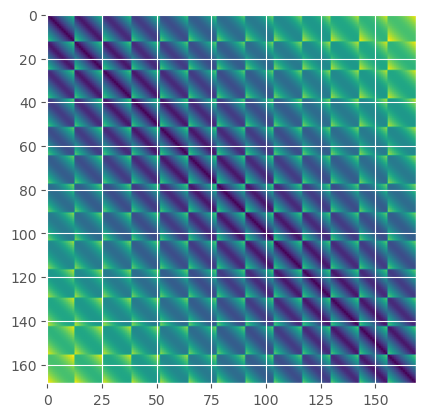

In [35]:
length = int(np.sqrt(num_patches))
assert length**2 == num_patches, "Num patches is not perfect square"

distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
plt.imshow(distance_matrix)
print(distance_matrix)

In [ ]:
#ex_imgs, ex_gt, pred_labels, attn_weights_dict

Num Heads: 8.


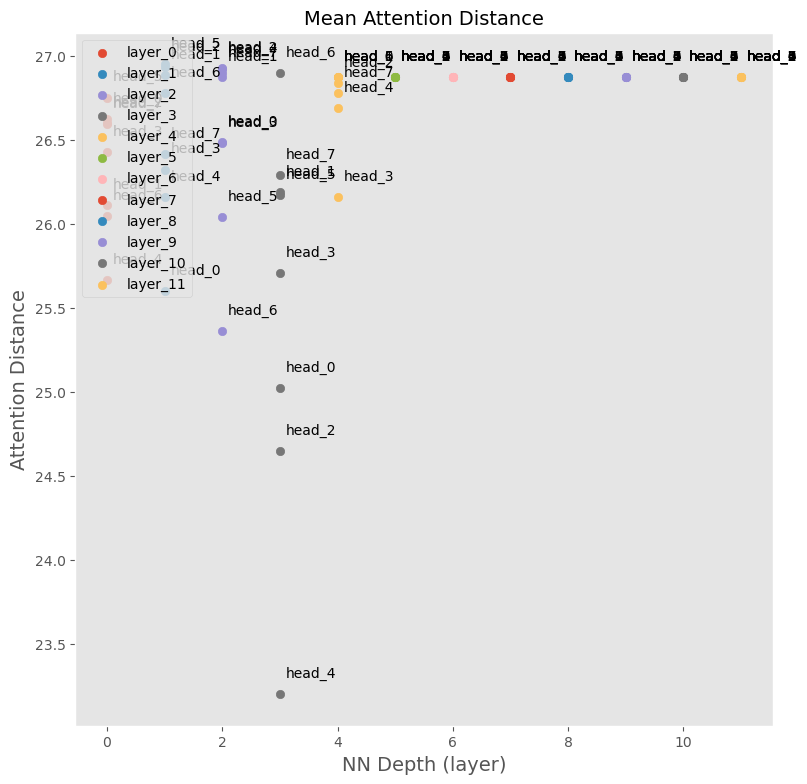

In [36]:
visualize_MAHD(attn_weights_dict, patch_size, num_heads)

## Attention Rollout

Abnar et al. introduce "Attention rollout" for quantifying how information flow through self-attention layers of Transformer blocks. Original ViT authors use this method to investigate the learned representations, stating:


> *Briefly, we averaged attention weights of ViTL/16 across all heads and then recursively multiplied the weight matrices of all layers. This accounts for the mixing of attention across tokens through all layers.*




In [75]:
def attention_rollout_map(image, attention_score_dict, img_id):
  num_cls_tokens = 1 #+1 in the attention dimensions

  # Stack the individual attention matrices from individual Transformer blocks.
  attn_mat = torch.stack([attention_score_dict[k][img_id, :, :, :] for k in attention_score_dict.keys()]) #(num_layers, num_heads, num_patches+1, num_patches+1)
  #print(torch.stack([torch.from_numpy(np.array(int(k[-1]))) for k in attention_score_dict.keys()]))
  # order of the layers in the stack: layer_0, layer_1, ... (stacks vertically)
  attn_mat = torch.squeeze(attn_mat, axis=1)
  #print(attn_mat.size())

  # Average the attention weights across all heads.
  attn_mat = torch.mean(attn_mat, axis=1) #(num_layers, num_patches+1, num_patches+1)
  #print(attn_mat.size())

  # To account for residual connections, we add an identity matrix to the
  # attention matrix and re-normalize the weights.
  residual_attn = torch.eye(attn_mat.size(1))
  aug_attn_mat = attn_mat + residual_attn
  aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
  #print(aug_attn_mat.sum(dim=-1).unsqueeze(-1).size()) #(num_layers, num_patches+1, 1)
  #aug_attn_mat  = (num_layers, num_patches+1, num_patches+1)

  # Recursively multiply the weight matrices of each layer
  joint_attentions = torch.zeros(aug_attn_mat.size())
  joint_attentions[0] = aug_attn_mat[0]

  for n in range(1, aug_attn_mat.shape[0]):
    joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n -1]) #respecting the order of attention multiplication: H = An...A0V

  # Attention from the output token to the input space.
  v = joint_attentions[-9] # #product of all layers' weight matrices multiplication
  grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
  mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size).numpy() #CLS token attention: (1,num_patches) --> (num_patches_per_dim, num_patches_per_dim)
  print(F.softmax(v[0, num_cls_tokens:], dim=-1))
  print(mask)
  mask = cv2.resize(mask / mask.max(), image.shape)
  print(mask.min(), mask.max())
  #result = compute_cam(mask, image)
  result = (mask * image).astype("uint8")
  print(result.min(), result.max())
  return result, mask

def visualize_attention_rollout(image, predicted_label, gt_label, attention_score_dict, img_id):
  image = image[0,:,:]
  attn_rollout_result, mask = attention_rollout_map(
      image, attention_score_dict, img_id
  )

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 13))
  fig.suptitle(f"GT label: {gt_label}, Predicted label: {predicted_label}.", fontsize=20)
  n_ticks = np.sqrt(num_patches) + 1

  _ = ax1.imshow(image, cmap='gray') #cmap='gray'
  _ = ax2.imshow(attn_rollout_result, cmap='gray') # cmap='gray'
  _ = ax3.imshow(mask, cmap='gray')
  ax1.set_title("Input Image", fontsize=16)
  ax2.set_title("Attention Map", fontsize=16)
  ax2.set_title("Attention Mask", fontsize=16)
  ax1.set_xticks(np.arange(n_ticks)*patch_size)
  ax1.set_yticks(np.arange(n_ticks)*patch_size)
  ax2.set_xticks(np.arange(n_ticks)*patch_size)
  ax2.set_yticks(np.arange(n_ticks)*patch_size)
  ax3.set_xticks(np.arange(n_ticks)*patch_size)
  ax3.set_yticks(np.arange(n_ticks)*patch_size)

  fig.tight_layout()
  fig.subplots_adjust(top=1.60)
  fig.show()

0.0 201.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0060, 0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0060, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0060, 0.0059, 0.0059

/tmp/ipykernel_208342/4103981532.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


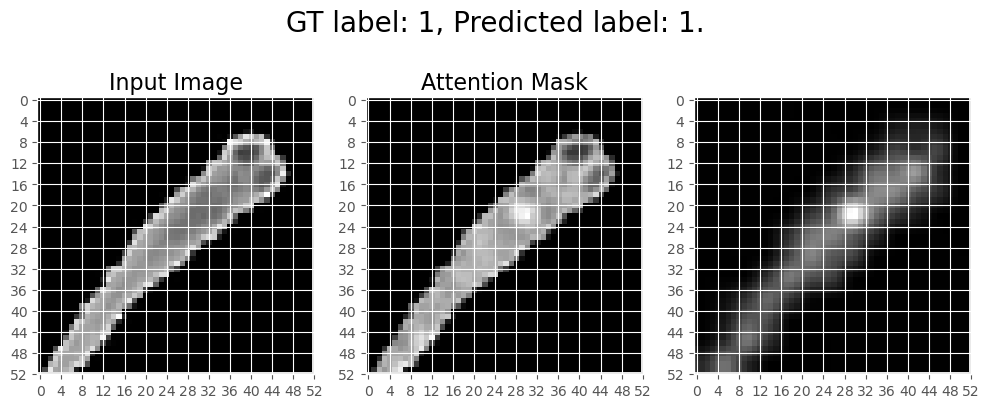

In [76]:
img_id = 0
#ex_imgs, ex_gt, pred_labels, attn_weights_dict
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

In [72]:
print(attn_weights_dict['layer_11'].size())
print(attn_weights_dict['layer_11'])

torch.Size([9, 8, 170, 170])
tensor([[[[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          ...,
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]],

         [[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          ...,
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]],

         [[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
          [0.

0.0 201.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059

/tmp/ipykernel_208342/1434210050.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


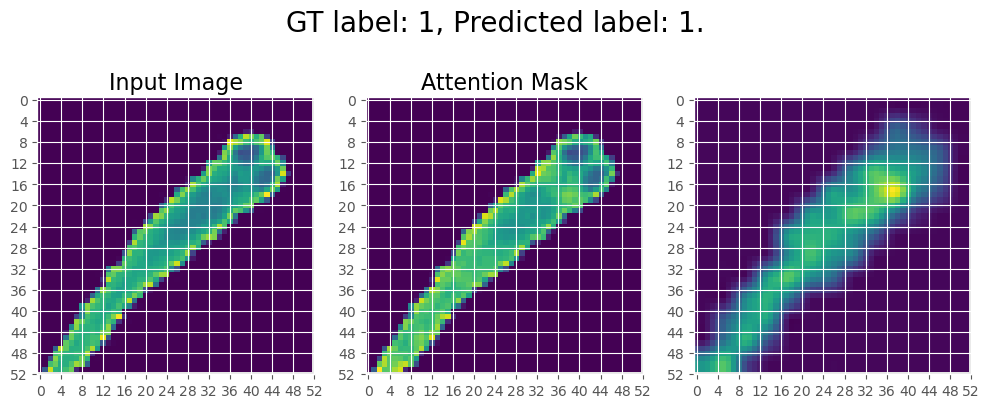

In [42]:
img_id = 0
#ex_imgs, ex_gt, pred_labels, attn_weights_dict
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 204.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059

/tmp/ipykernel_208342/1434210050.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


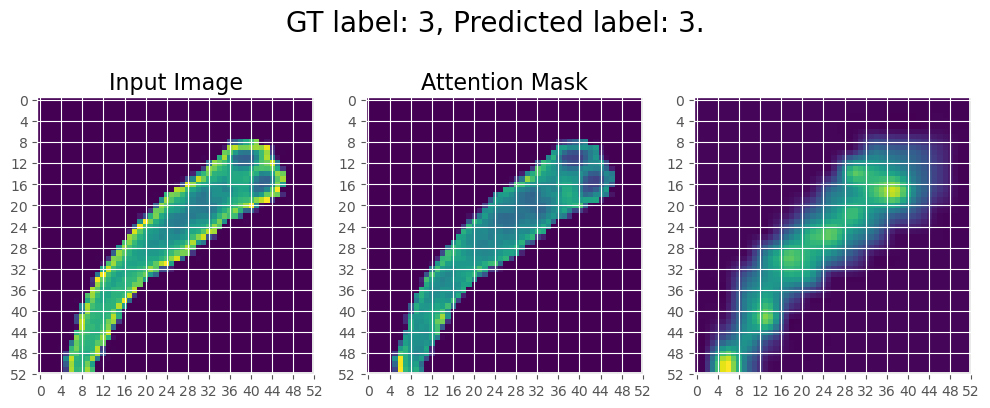

In [43]:
img_id = 1
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 189.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0060, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0060, 0.0060,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0060, 0.0060, 0.0059

/tmp/ipykernel_208342/4103981532.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


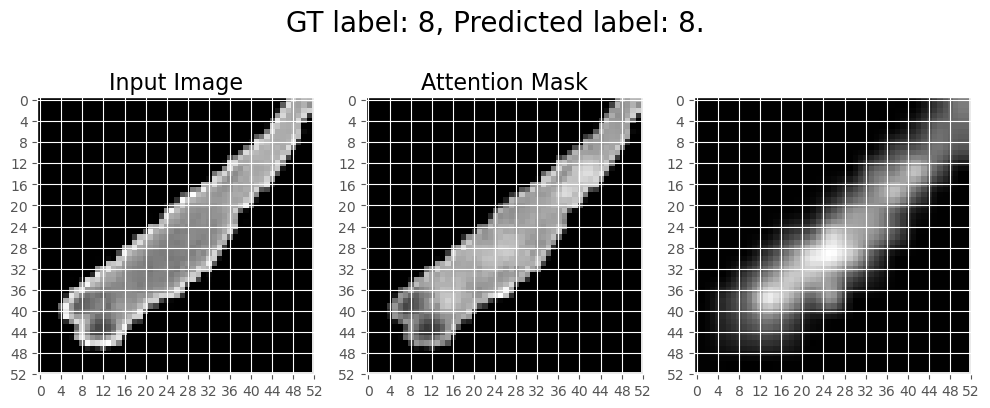

In [77]:
img_id = 2
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 189.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059

/tmp/ipykernel_208342/1434210050.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


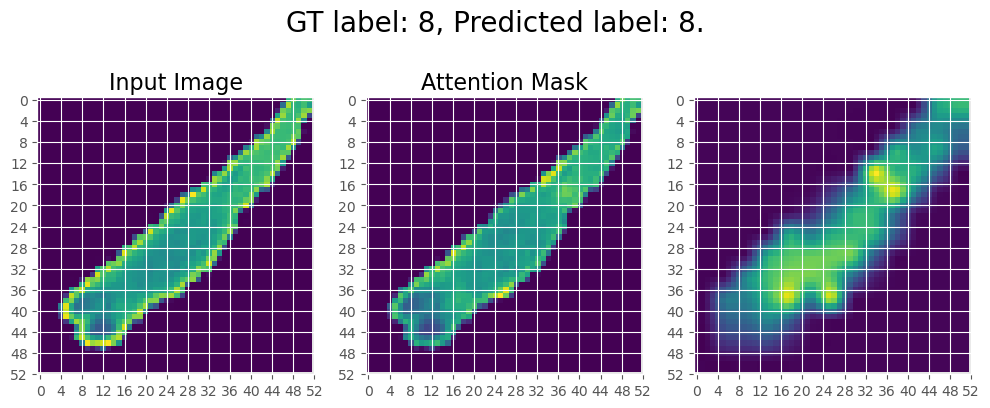

In [45]:
img_id = 2
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 195.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0060, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0060, 0.0060, 0.0060,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0060, 0.0060, 0.0060

/tmp/ipykernel_208342/4103981532.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


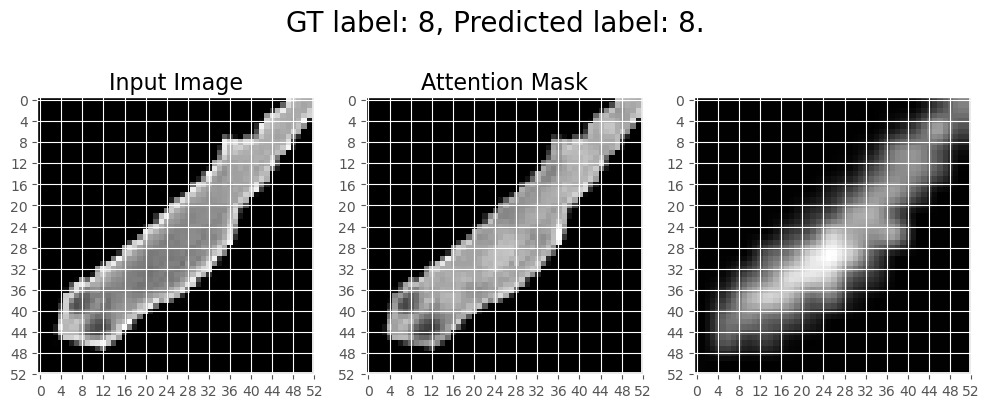

In [78]:
img_id = 4
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 195.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059

/tmp/ipykernel_208342/1434210050.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


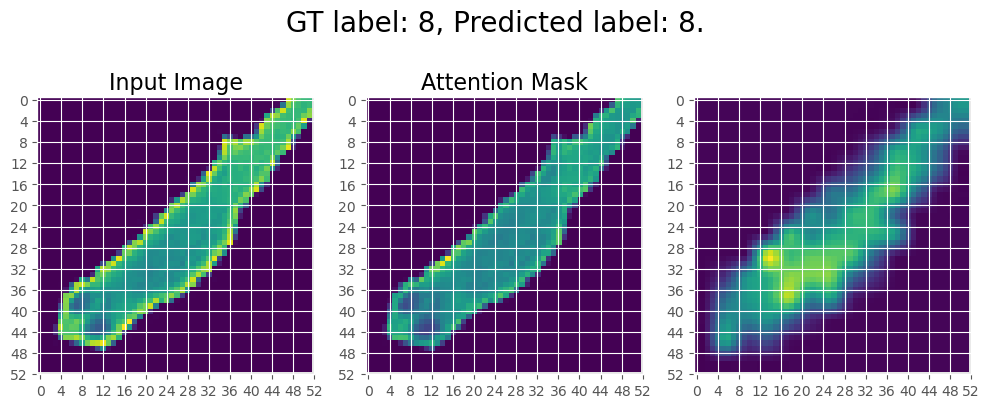

In [46]:
img_id = 4
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

0.0 207.0
tensor([0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
        0.0059, 0.0059, 0.0059

/tmp/ipykernel_208342/1434210050.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


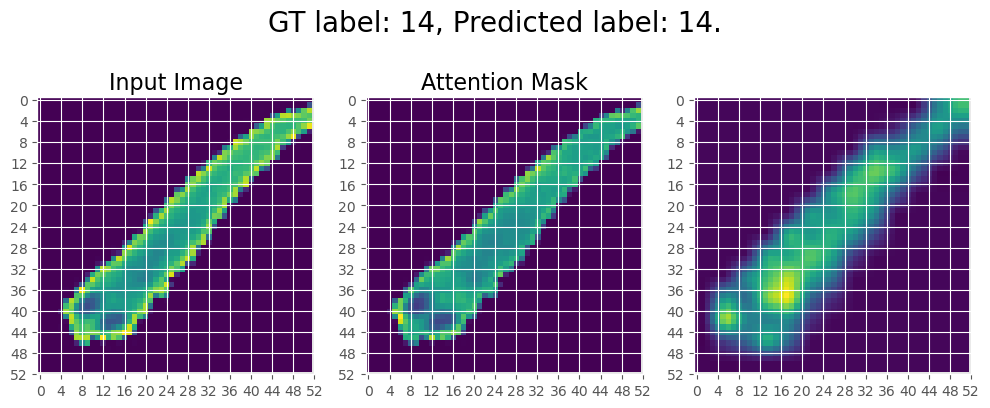

In [44]:
img_id = -1
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

# De-normalization
preprocessed_img_orig = (preprocessed_img_orig * std) + mean
print(preprocessed_img_orig.min(), preprocessed_img_orig.max())

visualize_attention_rollout(preprocessed_img_orig, predicted_label, gt_label, attn_weights_dict, img_id)

## Attention Heatmaps

A Transformer block consists of multiple heads. Each head in a Transformer block projects the input data to different sub-spaces. This helps each individual head to attend to different parts of the image. Therefore, it makes sense to visualize each attention head map seperately, to make sense of what each heads looks at.

In [65]:
def attention_heatmap(attention_score_dict, image, img_id, patch_size, num_heads):
    num_prefix_tokens = 1 #CLS token

    # Sort the Transformer blocks in order of their depth.
    attention_score_list = list(attention_score_dict.keys())
    attention_score_list.sort(key=lambda x: int(x.split("_")[-1]), reverse=True)

    # Process the attention maps for overlay.
    w_featmap = image.shape[2] // patch_size #=number of patches per dimension
    h_featmap = image.shape[1] // patch_size
    attention_scores = attention_score_dict[attention_score_list[8]] #take the last key (last layer)
    print(attention_score_list[8])

    # Taking the representations from CLS token.
    attentions = attention_scores[img_id, :, 0, num_prefix_tokens:].reshape(num_heads, -1)
    print(F.softmax(attentions, dim=-1))
    print(attentions.shape)

    # Reshape the attention scores to resemble mini patches.
    attentions = attentions.reshape(num_heads, h_featmap, w_featmap)
    print(attentions[0,:,:])
    print(attentions[7,:,:])

    # Resize the attention patches to the original image size
    attentions = torchvision.transforms.Resize(
         size=(h_featmap * patch_size, w_featmap * patch_size)
    )(attentions)

    return attentions.numpy() #(num_heads, h, w)

def visualize_attention_heatmaps(attention_score_dict, image, predicted_label, gt_label, img_id, patch_size, num_heads):
  # Generate the attention heatmaps.
  attentions = attention_heatmap(attention_score_dict, image, img_id, patch_size, num_heads)
  #print(attentions.shape)

  # Plot the maps.
  fig, axes = plt.subplots(nrows=int(num_heads/4), ncols=4, figsize=(10, 10))
  fig.suptitle(f"GT label: {gt_label}, Predicted label: {predicted_label}.", fontsize=20)
  n_ticks = np.sqrt(num_patches) + 1
  for h in range(num_heads):
    i = h//4
    j = h - (i*4)
    axes[i, j].imshow(image[0])
    axes[i, j].imshow(attentions[h, :, :], cmap="inferno", alpha=0.6)
    axes[i, j].title.set_text(f"Attention head: {h}")
    #axes[i, j].axis("off")
    axes[i, j].set_xticks(np.arange(n_ticks)*patch_size)
    axes[i, j].set_yticks(np.arange(n_ticks)*patch_size)

  plt.tight_layout()
  fig.subplots_adjust(top=1.1)

In [62]:
attn_weights_dict

{'layer_0': tensor([[[[0.0076, 0.0053, 0.0053,  ..., 0.0053, 0.0053, 0.0053],
           [0.0019, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007],
           [0.0019, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007],
           ...,
           [0.0019, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007],
           [0.0019, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007],
           [0.0019, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]],
 
          [[0.0038, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
           [0.0082, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
           [0.0082, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
           ...,
           [0.0082, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
           [0.0082, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021],
           [0.0082, 0.0021, 0.0021,  ..., 0.0021, 0.0021, 0.0021]],
 
          [[0.0054, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
           [0.0051, 0.0052, 0.0052,  ..., 0.0052, 0.0052, 0.0052],
           [0

layer_11
tensor([[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        ...,
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]])
torch.Size([8, 169])
tensor([[0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,

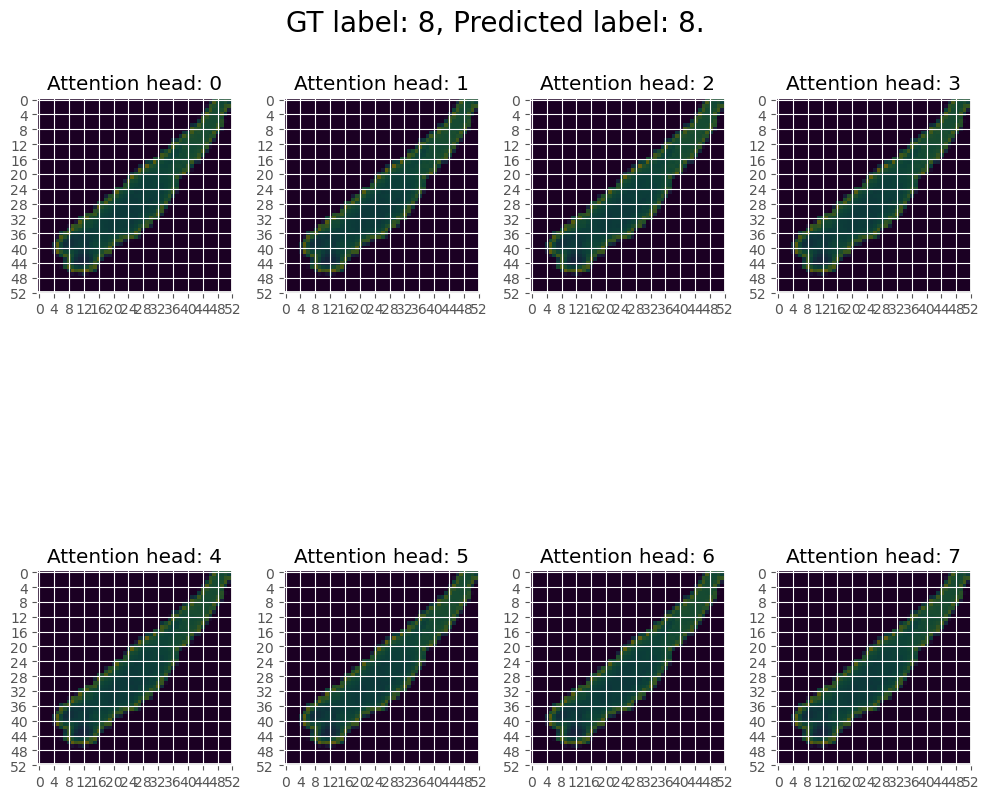

In [61]:
img_id = 2
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

layer_11
tensor([[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        ...,
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]])
torch.Size([8, 169])
tensor([[0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,

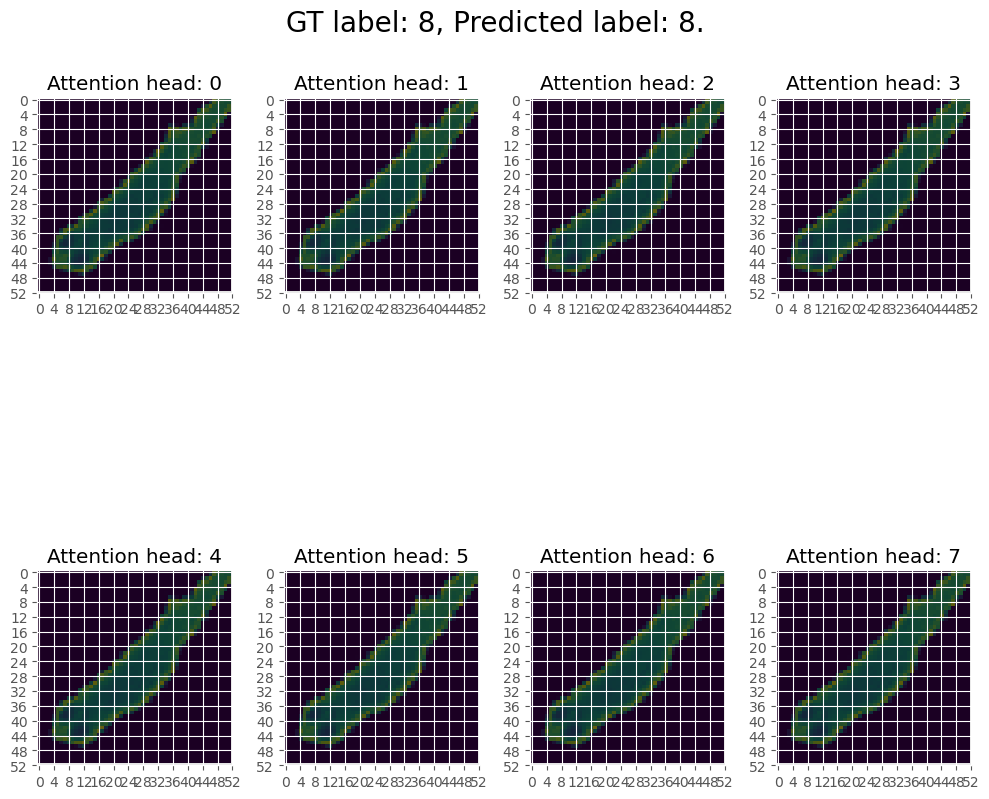

In [63]:
img_id = 4
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

layer_11
tensor([[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        ...,
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]])
torch.Size([8, 169])
tensor([[0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,
         0.0059, 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059, 0.0059,

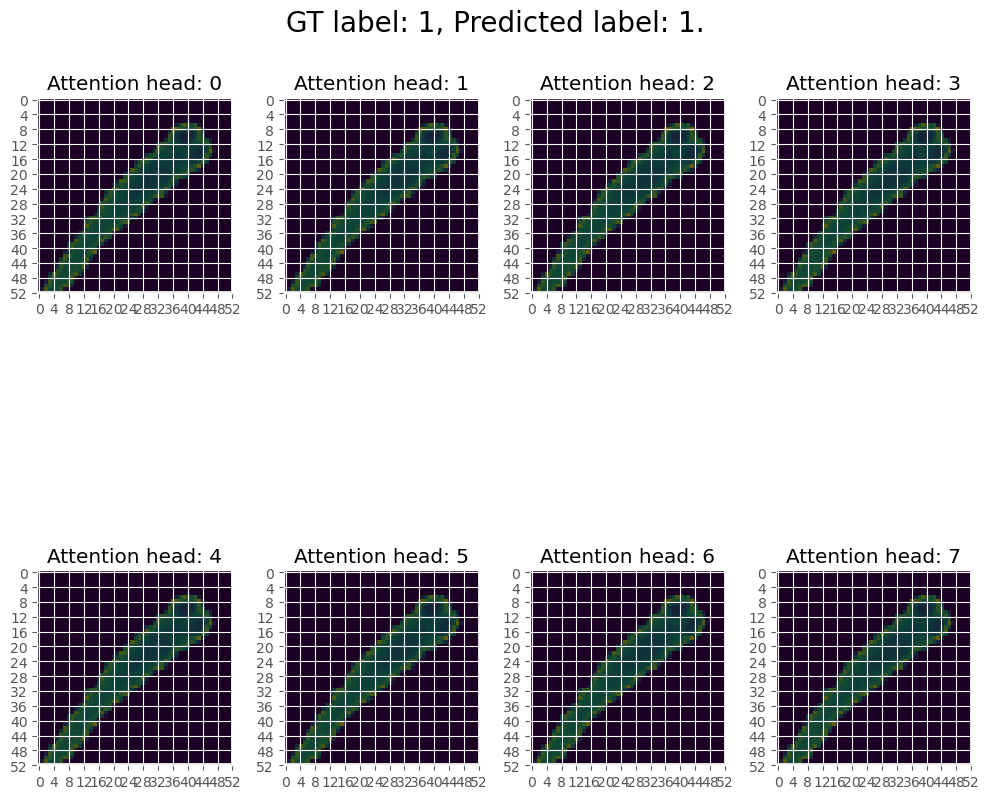

In [64]:
img_id = 0
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

layer_3
tensor([[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        ...,
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]])
torch.Size([8, 169])
tensor([[0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
         0.0014, 0.0014, 0.0131, 0.0232],
        [0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
         0.0014, 0.0021, 0.0100, 0.0050],
        [0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
         0.0078, 0.0106, 0.0317, 0.0015],
        [0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0108,
         0.0115, 0.0231, 0.0034, 0.0014],
        [0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0015, 0.0014, 0.0223, 0.0208,


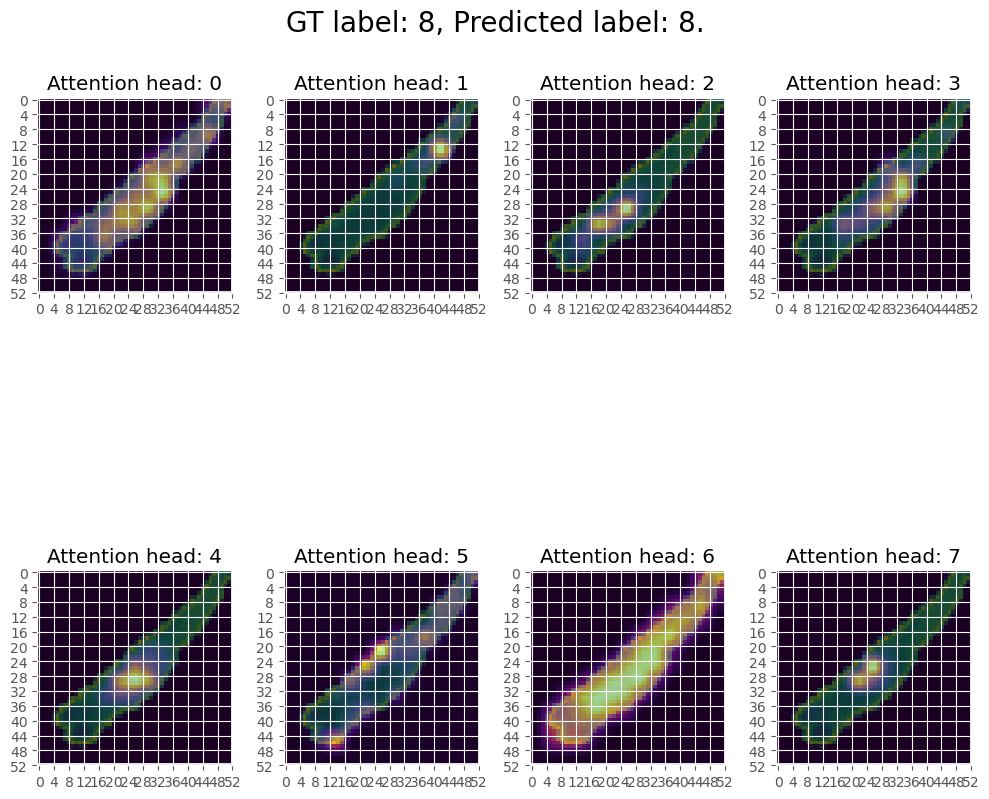

In [66]:
img_id = 2
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

layer_3
tensor([[0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        ...,
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059],
        [0.0059, 0.0059, 0.0059,  ..., 0.0059, 0.0059, 0.0059]])
torch.Size([8, 169])
tensor([[0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
         0.0015, 0.0014, 0.0203, 0.0160],
        [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014,
         0.0015, 0.0184, 0.0169, 0.0028],
        [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0016, 0.0069,
         0.0179, 0.0182, 0.0112, 0.0015],
        [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0014, 0.0098,
         0.0130, 0.0238, 0.0017, 0.0015],
        [0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0016, 0.0016, 0.0145, 0.0230,


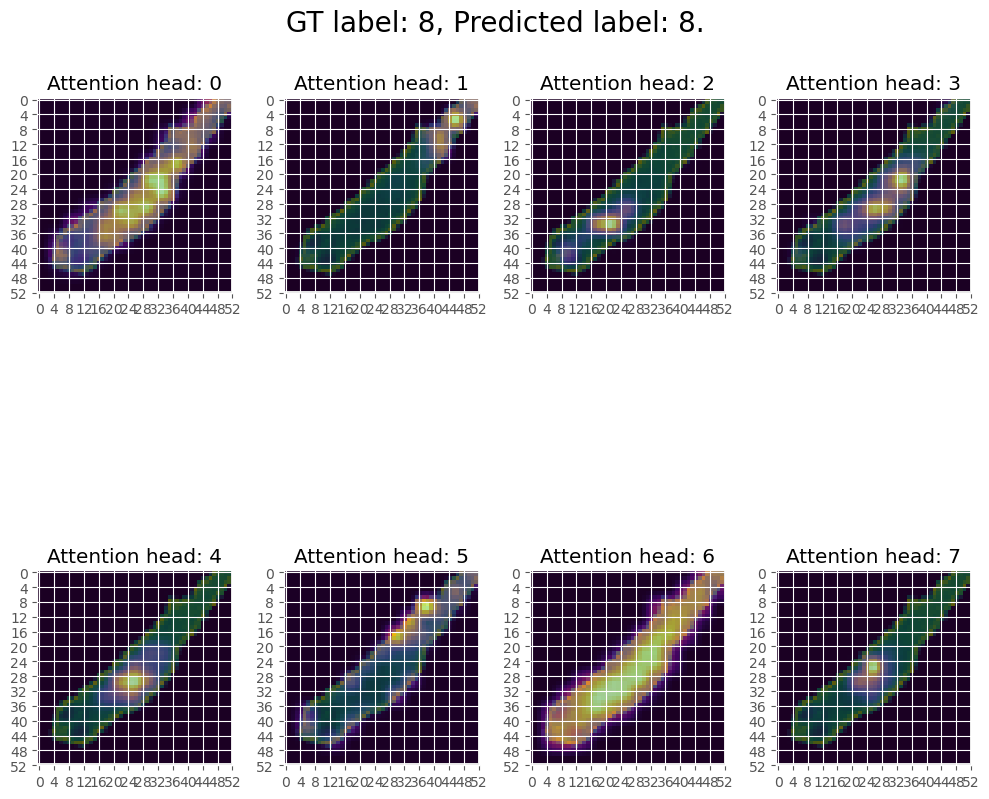

In [67]:
img_id = 4
preprocessed_img_orig, predicted_label, gt_label = ex_imgs[img_id], pred_labels[img_id], ex_gt[img_id]

visualize_attention_heatmaps(attn_weights_dict, preprocessed_img_orig, predicted_label, gt_label, img_id, patch_size, num_heads)

## Patch Embeddings

In [68]:
patch_embeddings = best_model_cp['model_state_dict']['embedding.patch_embeddings.weight']
#shape = [d_model, in_channels, patch_size, patch_size] = [64,1,7,7]--> 64 different kernels applied over 7x7 pixels/patch_dim
patch_embeddings = torch.reshape(patch_embeddings, (patch_size, patch_size, model.d_model)) #shape = (49, 64)
print(patch_embeddings.size())
#MAYBE RESHAPE to 7,7,64 and see the 2D kernels (search for a pattern)
patch_embeddings_np = patch_embeddings.cpu().data.numpy()

torch.Size([4, 4, 32])


In [ ]:
patch_embeddings_bias = best_model_cp['model_state_dict']['embedding.patch_embeddings.bias']
patch_embeddings_bias.size()

torch.Size([64])

In [ ]:
def TSNE_pembeddings(imgs):
  N = imgs.shape[0]
  x = torch.from_numpy(imgs).float().to(device)
  x_emb = model.embedding.patch_embeddings(x)
  #bs, num_kernels, h, w = x_emb.size()
  x_emb = x_emb.flatten(2).transpose(1, 2) #(bs, h*w, num_kernels)
  print(f"Range of values of the learned patch embeddings: [{x_emb.min()}, {x_emb.max()}]")
  X = x_emb.flatten(1)
  E = TSNE(n_components=3).fit_transform(X.detach().cpu())
  return E

def visualize_TSNE(E, Y, Y_pred, fig_name='TSNE_PE_test'):
  # set up a figure twice as wide as it is tall
  fig = plt.figure(figsize=(15,20))
  # =============
  # First subplot
  # =============
  # set up the axes for the first plot
  ax = fig.add_subplot(2, 1, 1, projection='3d')

  s = ax.scatter(E[:,0], E[:,1], E[:,2], c=Y, cmap='tab10')
  ax.grid(False)
  ax.set_title("GT labels")
  fig.colorbar(s, shrink=0.5, ticks=np.arange(10), boundaries=np.arange(11) - .5)

  ax_ = fig.add_subplot(2, 1, 2, projection='3d')

  s_pred= ax_.scatter(E[:,0], E[:,1], E[:,2], c=Y_pred, cmap='tab10')
  ax_.grid(False)
  ax_.set_title("Pred labels")
  fig.colorbar(s_pred, shrink=0.5, ticks=np.arange(10), boundaries=np.arange(11) - .5)
  plt.savefig('{}results/plots/{}/{}.png'.format(base_path, model_name, fig_name))

In [ ]:
all_imgs, all_gt, all_pred_labels, _, _ = test_model(model, val_loader_plots, n=None)

In [ ]:
print(all_imgs.shape, all_gt.shape, all_pred_labels.shape)
#print(all_gt, all_pred_labels)

(1000, 1, 52, 52) (1000,) (1000,)
[10  3 10  3  3  8  2  5 13  2  6  5  9  0  1  9  3  0  9  0  8  4  2 13
  6  0  8  8 10 12 10  5  3  3  5  2 10 12 14 10  2  2  9  6  2 12  9  2
  5  2  5  4  3  2  9 11  7  1  9  8  5  0 12  5  3  5  7  0  2  5  5  7
  0 12  3 13 14  0  1  9  0  7  1  4  7 13  4 13 14 11  2  1 11 14  6 13
  9  4  1  8 12 14 12  4  0 13 13  1  7  2  1  5  2  7  3  9 11 14  6  0
  6  5 11  1  7 14  8  5 12  7  4 10 10 12  1  2 11  3 12 12  5  3  0  3
  2  0  8  6 12  7 10 11 12 10 12  9  0  0  4  0  6  3  5  4 11  5 12  8
  7 11  5  4  9  7 14  7 13 14  5  7 12  7  1  2  8 11 11  5  2  5  1 13
  3  8 12 13 13 10 11 10  1 12 11  0 12  0  0 12  0 10  2  9  9  4  0  8
 12 12  2 11  3  0  9 11 11 12  8  9  1 11 13  3  9  8  0  2  8 12 14  5
  7 13  0  6  9  8 14  5  0 12 14  9  4  8  3  5  2  4  6  2 12  6  9  0
  7  7 13 11 12 12  5 10  1  3 12  0  6  5 14 12 14  7 11 11  1 14  3 10
  4 13  1  1 11  5 10  6 11  6  9 10  1  3 10  6 14  4 13  8  3 13  4  1
 11 14  0  7 13  

Range of values of the learned patch embeddings: [-7.07756233215332, 6.236696243286133]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


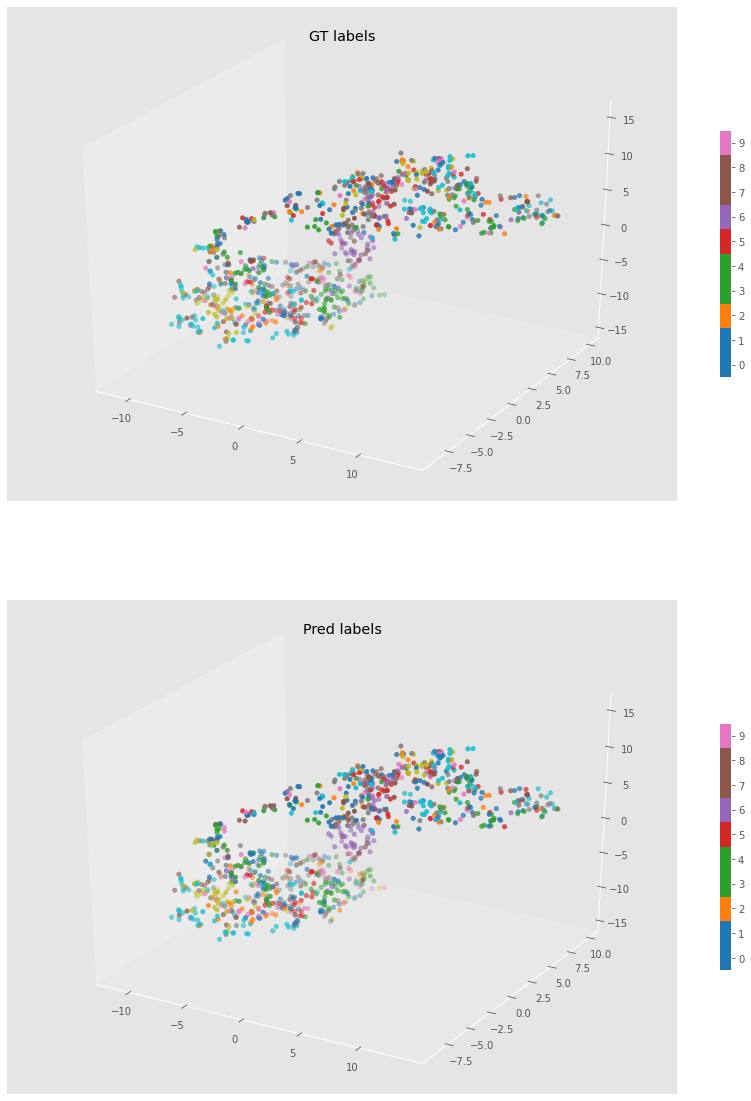

In [ ]:
E = TSNE_pembeddings(all_imgs)
visualize_TSNE(E, all_gt, all_pred_labels, fig_name='TSNE_PE_val')

In [ ]:
wrong_pred = np.where(all_gt!=all_pred_labels)[0]
incorrect = wrong_pred.shape[0] / all_pred_labels.shape[0] * 100
print("Rate of correct prediction: ", 100 - incorrect)

count_wp = {}
for id in wrong_pred:
  gt , pred = all_gt[id], all_pred_labels[id]
  if gt not in count_wp.keys():
    count_wp[gt] = [pred]
  else:
    count_wp[gt].append(pred)

Rate of correct prediction:  82.9


In [ ]:
#for each gt label,  shows the wrong predicted labels (Confusion between labels)
for gt in count_wp.keys():
  print(gt, ': ' ,count_wp[gt])

10 :  [5, 12, 5, 12, 13, 8, 12, 9, 0, 13, 12, 13, 8, 13, 12, 12]
13 :  [14, 11, 2, 7, 10, 11, 7, 12, 11, 0]
12 :  [2, 10, 10, 2, 13, 10, 2, 13, 2, 10, 10]
5 :  [1, 1, 6, 0, 0, 6, 10, 6, 6, 6, 1, 2, 0, 10, 6, 6, 1, 10, 10]
14 :  [7, 11, 11, 1, 11, 11]
2 :  [0, 1, 3, 5, 10, 5, 11, 10, 5, 1, 12, 12, 12, 0, 13, 14]
11 :  [4, 9, 13, 1, 0, 10, 7, 8, 9, 9, 0, 8, 8, 14, 0, 0, 9, 9, 9, 7, 1, 0, 9, 9]
1 :  [2, 0, 0, 0, 3, 10, 3, 0, 6, 9, 9, 9, 0, 0]
7 :  [11, 3, 6, 4, 8, 9]
0 :  [9, 1, 1, 1, 9, 10, 9, 9, 1, 9, 5, 1, 11, 1, 2, 9]
9 :  [8, 1, 1, 8, 0, 1, 11, 0]
8 :  [9]
4 :  [9, 7, 9, 3]
3 :  [14, 4, 2, 1, 12, 2, 4, 11, 1, 4, 4, 1, 2, 1, 1]
6 :  [5, 1, 1, 1, 1]


## Pos Embeddings

In [ ]:
pos_embeddings = best_model_cp['model_state_dict']['pos_embed.pe']
# shape = [1, num_patches + 1, d_model] = [1,17,64]
pos_embeddings = torch.reshape(pos_embeddings, (-1, model.d_model)) #shape = (17, 64)
print(pos_embeddings.size())
pos_embeddings_np = pos_embeddings.cpu().data.numpy()

torch.Size([170, 16])


In [ ]:
print(pos_embeddings_np.min(), pos_embeddings_np.max())

-3.6780512 3.4118905


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
def visualize_pe2D(pe):
  n_patches_perdim = int(math.sqrt(num_patches))
  #pe_2D = pe.reshape(n_patches_perdim, n_patches_perdim, -1) #size=(num_patches, d_model)

  cos_similarity = np.zeros((n_patches_perdim, n_patches_perdim, num_patches))

  for row in range(cos_similarity.shape[0]):
    for col in range(cos_similarity.shape[1]):
      #patch = pe_2D[np.newaxis,row, col, :]
      patch = pe[row*n_patches_perdim + col, :] #size=(1,64)
      sim = cosine_similarity(patch[np.newaxis, ...], pe) #size=(1,num_patches)
      cos_similarity[row, col, :] = sim

  fig, ax = plt.subplots(n_patches_perdim, n_patches_perdim, figsize=(12,12))
  for i in range(n_patches_perdim):
    for j in range(n_patches_perdim):
      patch_sim = cos_similarity[i,j,:].reshape(n_patches_perdim, n_patches_perdim)
      #plots the cos sim between the patch corresponding to position (i,j) in the image and all the other patches
      im = ax[i,j].imshow(patch_sim, vmin=-1.)
      if j==0:
        ax[i,j].set_ylabel(f"Row_{i}")
      if i==n_patches_perdim-1:
        ax[i,j].set_xlabel(f"Col_{j}")

  im.cmap.set_under("w")
  cbar = fig.colorbar(im, ax=ax.ravel().tolist(), label='Intensity')
  return cos_similarity

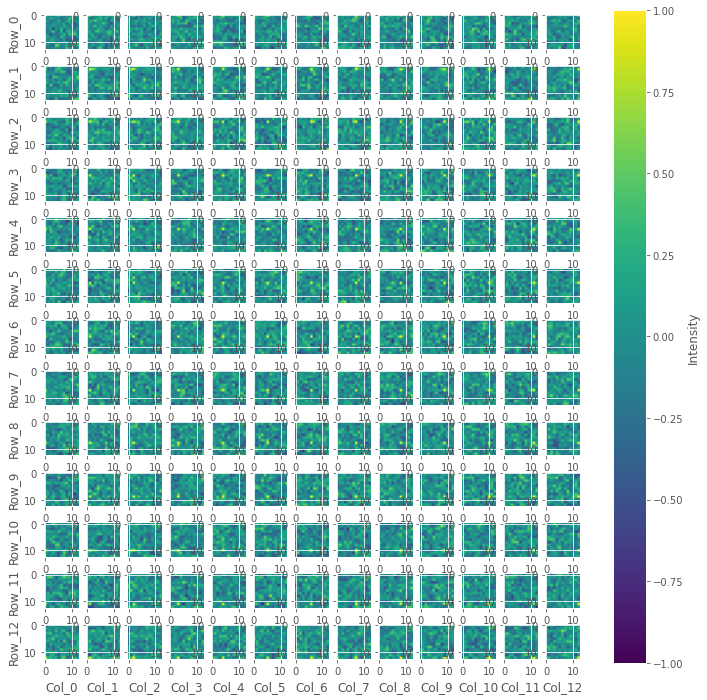

In [ ]:
position_embeddings = pos_embeddings_np[1:, ...]
c = visualize_pe2D(position_embeddings)